In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# Import geomap of the Netherlands
mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
mapdf = mapdf[mapdf["H2O"] == "NEE"]
mapdf.sort_values("GM_NAAM", inplace=True)
mapdf = mapdf.reset_index(drop=True)
print(mapdf.columns)

# Compute distances between all municipalities
mapdf['GEO_CENTROID'] = mapdf.centroid
centres = mapdf['GEO_CENTROID']
n_mun = mapdf.shape[0]

# dist_matrix = np.zeros(shape=(n_mun, n_mun))
# for i in range(0, n_mun):
#     dist_matrix[i] = centres.distance(centres[i])

# Compute mobility based gravity model, without distances
population = mapdf['AANT_INW']
mob_matrix = np.zeros(shape=(n_mun, n_mun))
for i in range(0, n_mun):
    for j in range(0, n_mun):
        if i != j:
            mob_matrix[i,j] = population[i] * population[j]

# Import original data to normalize to
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

# Normalize row sums to original data, so total amount traveled per municipality is the same.
mob_matrix_freq = np.zeros(shape=(n_mun, n_mun))
mob_matrix_inc = np.zeros(shape=(n_mun, n_mun))
for i in range(n_mun):
    diff_freq = np.nansum(mob_matrix[i]) / np.nansum(mobmat_freq[i])
    mob_matrix_freq[i] = mob_matrix[i] / diff_freq

    diff_inc  = np.nansum(mob_matrix[i]) / np.nansum(mobmat_inc[i])
    mob_matrix_inc[i] = mob_matrix[i] / diff_inc

# Save the new matrix
path = os.getcwd() + '/Data/'
np.save(path + 'Randomized_mob_grav_freq', mob_matrix_freq)
np.save(path + 'Randomized_mob_grav_inc', mob_matrix_inc)

Index(['GM_CODE', 'GM_NAAM', 'H2O', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR',
       ...
       'AV20PODIUM', 'AF_MUSEUM', 'AV5_MUSEUM', 'AV10MUSEUM', 'AV20MUSEUM',
       'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=205)


In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import pandas as pd
import numpy as np
import os

ppl_per_agent = 100

path_gem_names = os.getcwd() + '/Data/Gem_alfabetisch_2018.csv'

DF_Gem = pd.read_csv(path_gem_names, delimiter=';', encoding='latin-1')
UniLocs = np.unique(DF_Gem.Gemeentenaam)
UniIDs = [list(DF_Gem.GemeentecodeGM[DF_Gem.Gemeentenaam == i])[0] for i in UniLocs]

path_demo = os.getcwd() + '/Data/DemographicMatrix.csv'

DF_Demo = pd.read_csv(path_demo, delimiter=',')
DemoIDs = np.array(DF_Demo['Unnamed: 0'])
DemoMat_unsorted = np.array(DF_Demo[DF_Demo.keys()[1:]])
DemoMat_sorted = []
for ID in UniIDs:
    DemoMat_sorted.append(DemoMat_unsorted[DemoIDs == int(ID.lstrip('GM'))])
DemoMat = (np.array(DemoMat_sorted)/ppl_per_agent).astype(int)[:, 0]

DemoFractionsMat = np.zeros(shape=DemoMat.shape)
for i in range(0, DemoMat.shape[0]):
    DemoFractionsMat[i] = DemoMat[i] / np.sum(DemoMat[i])



# Useful functions
def create_spatial_plot(data_per_municipality, title, legend_label):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"})

    plt.plot()



def create_spatial_4plots(data_per_municipality, title, legend_label):
    '''
    Plot 4 maps, evenly spread out over time
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    max_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle(title)

    mapdf.insert(0, 'DATA_QUARTER', data_per_municipality[int(max_time/4)])
    mapdf.insert(0, 'DATA_HALF', data_per_municipality[int(max_time/2)])
    mapdf.insert(0, 'DATA_3QUARTER', data_per_municipality[int(max_time*3/4)])
    mapdf.insert(0, 'DATA_MAXTIME', data_per_municipality[max_time-1])

    mapdf.plot(ax=axs[0], column="DATA_QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[1], column="DATA_HALF", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[2], column="DATA_3QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[3], column="DATA_MAXTIME", norm=matplotlib.colors.LogNorm(1,max_val))


    axs[0].set_title('t=' + str(int(max_time/4)))
    axs[1].set_title('t=' + str(int(max_time/2)))
    axs[2].set_title('t=' + str(int(max_time*3/4)))
    axs[3].set_title('t=' + str(int(max_time-1)))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, max_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


# DAILY PLOT FOR 1 WEEK

def create_spatial_7plots(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot a daily map for 1 week
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = day + 1
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()

def create_spatial_7plots3_linear(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])
    min_legend_val = np.min(data_per_municipality[max_time-1])

    print(max_legend_val)
    print(min_legend_val)

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), legend=True)
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    plt.tight_layout()
    plt.plot()


def combine_runs_avg(all_run_data, padding=0.000001):
    merged_data = np.zeros(shape= all_run_data[0].shape)
    for i in range (0, len(all_run_data)):
        merged_data = merged_data + all_run_data[i]
    merged_data = (merged_data / len(all_run_data)) + padding
    return merged_data

def combine_demos_weighted(municipality_id, demo_run_data, padding=0.000001):
    fracs = DemoFractionsMat[municipality_id]
    merged_data = np.zeros(shape= demo_run_data[0].shape)
    for i in range (0, len(demo_run_data)):
        weighted = fracs[i] * demo_run_data[i]
        merged_data = merged_data + weighted
    merged_data = merged_data + padding
    return merged_data


In [31]:
import pandas as pd
import numpy as np
import os

def load_total_infected_per_municipality(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')
    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(path_data + 'Gemeenten.pkl')).T[0]
    loc_to_id = {val: i for i, val in enumerate(uniLocs)}
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        infected_agents = agents_status_t[(data_t == 2) | (data_t == 3)]
        infected_agents_homes = np.array(peopleDF.loc[infected_agents]['Home'])
        for home in infected_agents_homes:
            infected_per_municipality[t, loc_to_id[home]] += 1

    return infected_per_municipality

def load_total_infected_avg_runs(path_data, loc, group, runs):
    all_data = []
    for run in range(runs):
        all_data.append(load_total_infected_per_municipality(path_data, loc, group, run))
        print("Loaded & computed loc: " +str(loc) + " group: " + str(group) + " run: " + str(run)) 

    # Average the data
    merged_data = np.zeros(all_data[0].shape)
    for run in range(runs):
        merged_data = merged_data + all_data[run]
    merged_data = merged_data / runs
    return merged_data

0	's-Gravenhage:  131.4
1	's-Hertogenbosch:  110.15
2	Aa en Hunze:  87.75
3	Aalburg:  134.0
4	Aalsmeer:  118.85000000000002
5	Aalten:  87.45000000000002
6	Achtkarspelen:  69.2
7	Alblasserdam:  154.85
8	Albrandswaard:  117.65
9	Alkmaar:  124.20000000000002
10	Almelo:  85.15
11	Almere:  102.0
12	Alphen aan den Rijn:  120.65
13	Alphen-Chaam:  171.64999999999998
14	Ameland:  81.69999999999999
15	Amersfoort:  143.25
16	Amstelveen:  137.4
17	Amsterdam:  122.15
18	Apeldoorn:  114.75
19	Appingedam:  61.7
20	Arnhem:  105.50000000000001
21	Assen:  81.19999999999999
22	Asten:  103.8
23	Baarle-Nassau:  140.14999999999998
24	Baarn:  143.95
25	Barendrecht:  125.75
26	Barneveld:  125.75
27	Bedum:  135.29999999999998
28	Beek:  128.60000000000002
29	Beemster:  137.89999999999998
30	Beesel:  99.75
31	Berg en Dal:  109.5
32	Bergeijk:  107.15
33	Bergen (L.):  98.8
34	Bergen (NH.):  104.75
35	Bergen op Zoom:  117.25
36	Berkelland:  99.55000000000001
37	Bernheze:  104.1
38	Best:  101.0
39	Beuningen:  140.05

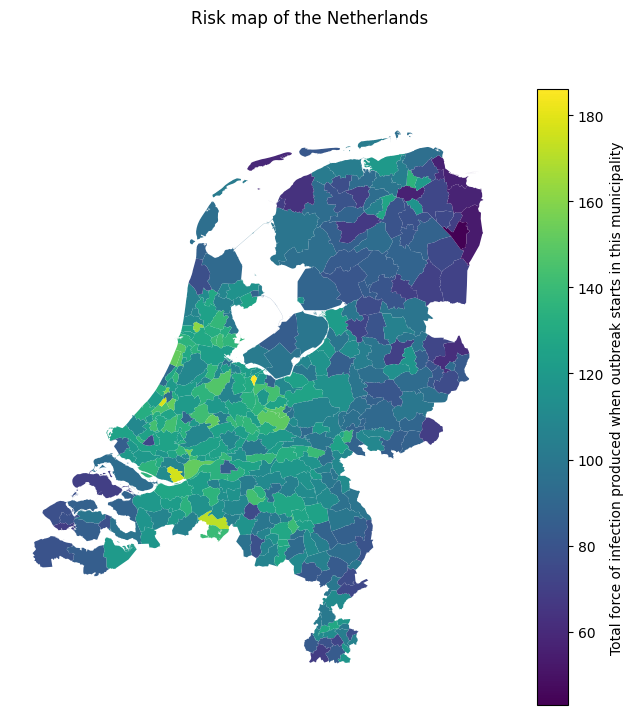

In [22]:
path = os.getcwd() + '/results/High/Seed_0/'

loc_name = np.array(pd.read_pickle(path + 'Gemeenten.pkl')).T[0]
n_mun = len(loc_name)
t_max = 21 * 24

risk_map = np.zeros(n_mun)
infected_per_municipality = np.zeros((n_mun, t_max, n_mun))
for loc in range(n_mun):
    infected_per_municipality[loc] = load_total_infected_avg_runs(path, loc, 3, 20)
    risk_map[loc] = np.sum(infected_per_municipality[loc, t_max - 1])
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk_map[loc]))

# Store the infected data per municipality, because it takes a while to generate
np.save(path + 'Infected_Per_Municipality', infected_per_municipality)

create_spatial_plot(risk_map, 'Risk map of the Netherlands', 'Total infected when outbreak starts in this municipality')



In [12]:
def load_foi_avg_runs(path_data, loc, group, runs):
    all_data = []
    for run in range(runs):
        foi_data = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Infection_Pressure_' + str(run) + '.npy')
        all_data.append(foi_data)

    # Average the data
    merged_data = np.zeros(all_data[0].shape)
    for run in range(runs):
        merged_data = merged_data + all_data[run]
    merged_data = merged_data / runs
    return merged_data

path = os.getcwd() + '/results/High/Seed_0/'

loc_name = np.array(pd.read_pickle(path + 'Gemeenten.pkl')).T[0]

risk_map = np.zeros(380)
for loc in range(380):
    infected_per_municipality = load_foi_avg_runs(path, loc, 3, 20)
    t_max = infected_per_municipality.shape[0]
    risk = np.sum(infected_per_municipality[t_max - 1])
    risk_map[loc] = risk
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk))

create_spatial_plot(risk_map, 'Risk map of the Netherlands for Students', 'Total force of infection produced when outbreak starts in this municipality')

0	's-Gravenhage:  5010.687865019083
1	's-Hertogenbosch:  4281.126078469872
2	Aa en Hunze:  3236.9916332889015
3	Aalburg:  4931.29562894513
4	Aalsmeer:  4454.93242866386
5	Aalten:  3295.9497352767403
6	Achtkarspelen:  2581.2499462129626
7	Alblasserdam:  5872.849743200089
8	Albrandswaard:  4325.8894669173205
9	Alkmaar:  4622.816659484675
10	Almelo:  3082.852190655681
11	Almere:  3711.5644195636405
12	Alphen aan den Rijn:  4761.599249703273
13	Alphen-Chaam:  6556.900646841899
14	Ameland:  2966.021582451159
15	Amersfoort:  5312.044109365914
16	Amstelveen:  5127.6830705350785
17	Amsterdam:  4627.7982086870525
18	Apeldoorn:  4253.422675861526
19	Appingedam:  2300.9025044553227
20	Arnhem:  3906.3644052458294
21	Assen:  2903.0128937052655
22	Asten:  3723.6685678398553
23	Baarle-Nassau:  5311.089184253737
24	Baarn:  5506.102073749405
25	Barendrecht:  4731.824503977183
26	Barneveld:  4563.17600562075
27	Bedum:  5032.958538063237
28	Beek:  4782.848142899767
29	Beemster:  5194.067526731286
30	Bees

179	Laren: 186.10000000000002
333	Voorschoten: 178.1
298	Strijen: 176.45
13	Alphen-Chaam: 171.64999999999998
313	Uitgeest: 161.7
232	Oegstgeest: 157.4
7	Alblasserdam: 154.85
372	Zoeterwoude: 152.64999999999998
366	Zandvoort: 152.4
85	Dordrecht: 151.70000000000002
251	Oudewater: 150.9
317	Utrechtse Heuvelrug: 150.35000000000002
362	Woudenberg: 150.20000000000002
44	Bloemendaal: 148.75
72	De Ronde Venen: 147.4
185	Leidschendam-Voorburg: 145.1
24	Baarn: 143.95
74	Delft: 143.54999999999998
125	Haaren: 143.5
15	Amersfoort: 143.25
178	Lansingerland: 143.09999999999997
176	Landsmeer: 141.85000000000002
45	Bodegraven-Reeuwijk: 141.75
253	Papendrecht: 141.10000000000002
229	Nuenen, Gerwen en Nederwetten: 140.75
244	Oostzaan: 140.2
23	Baarle-Nassau: 140.14999999999998
39	Beuningen: 140.05
90	Duiven: 139.05
162	IJsselstein: 139.0
118	Gorinchem: 138.5
29	Beemster: 137.89999999999998
218	Neerijnen: 137.85
16	Amstelveen: 137.4
191	Lisse: 137.3
266	Ridderkerk: 137.25
199	Maassluis: 136.95
159	Houten:

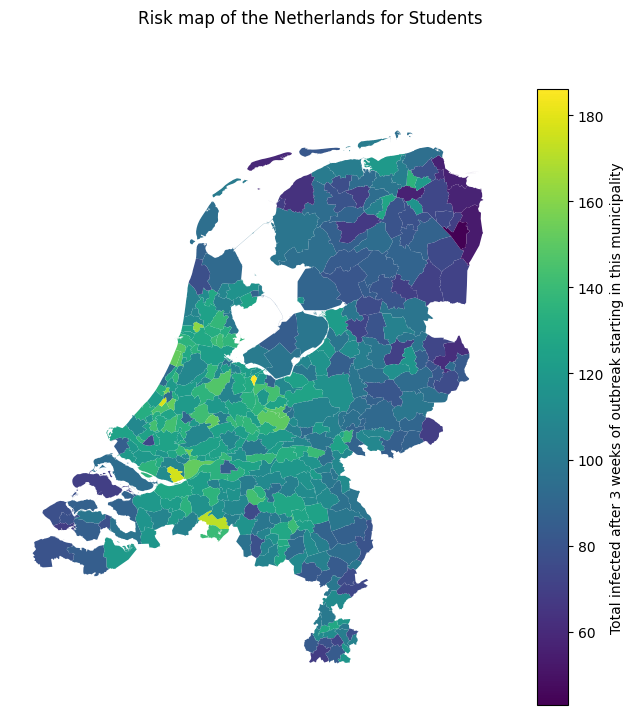

In [30]:
infected_per_municipality = np.load(os.getcwd() + '/results/High/Seed_0/Infected_Per_Municipality.npy')
n_municipalities = infected_per_municipality.shape[0]
risk_data = np.zeros(n_municipalities)
for i in range(n_municipalities):
    risk_data[i] = np.sum(infected_per_municipality[i, t_max - 1])

for loc in np.argsort(risk_data)[::-1]:
    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(risk_data[loc]))


create_spatial_plot(risk_data, 'Risk map of the Netherlands for Students', 'Total infected after 3 weeks of outbreak starting in this municipality')